In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor as nn
import sklearn.metrics as metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from panelsplit.cross_validation import PanelSplit
from panelsplit.application import cross_val_fit
from panelsplit.plot import plot_splits
from panelsplit.pipeline import SequentialCVPipeline
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import shap

c:\Users\Steven\Desktop\school github repos\svo-directed-practicum\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Define a utility function to take CV models and average them to output an ensemble
def extract_cv_fit(fit, X):
    predicts = [m.predict(X) for m in fit]
    mean = np.mean(predicts, axis=0)
    # create a DataFrame to hold both the mean and the individual predictions
    df = pd.DataFrame(predicts).T
    df.columns = [f'pred_{i+1}' for i in range(len(predicts))]
    df['pred_mean'] = mean

    return df

In [2]:
# Open the pickle file
reg_data = pickle.load(open('../data/processed/stock_data.pkl', 'rb'))
reg_data

%Chg                                                  \
ticker                AAL  ALGT   ALK   DAL   ITA   IYT  JBLU  JETS   LUV   
Time                                                                        
2022-05-05 09:30:00 -1.38  2.10 -1.66 -1.19 -0.70 -0.96 -1.75 -0.97 -0.85   
2022-05-05 09:45:00 -0.67 -0.92 -0.21 -0.20 -0.29 -0.09 -0.09 -0.35 -0.15   
2022-05-05 10:00:00 -0.31 -0.25 -0.29 -0.15 -0.65 -0.36 -0.36 -0.26  0.04   
2022-05-05 10:15:00 -0.47 -0.36 -0.57 -0.60 -0.08 -0.42 -0.62 -0.56 -0.49   
2022-05-05 10:30:00  0.16 -0.29 -0.29 -0.16 -0.08 -0.14  0.00  0.00 -0.14   
...                   ...   ...   ...   ...   ...   ...   ...   ...   ...   
2025-05-30 14:45:00  0.22  0.13  0.09  0.02  0.10  0.12  0.39  0.09  0.12   
2025-05-30 15:00:00  0.09 -0.03 -0.09  0.21  0.11  0.02 -0.39  0.07  0.21   
2025-05-30 15:15:00  0.26  0.21  0.24  0.35  0.22  0.18  0.29  0.22  0.21   
2025-05-30 15:30:00 -0.13 -0.11 -0.31 -0.24 -0.11 -0.14 -0.49 -0.09 -0.15   
2025-05-30 15:45:00 -0.35 -0.73 -0.66 -0.32  0.01  0.00 -0.98  0.00 -0.40   

                           ... ticker_Lag1                                  \
ticker                UAL  ...         AAL  ALGT  ALK  DAL  ITA  IYT  JBLU   
Time                       ...                                               
2022-05-05 09:30:00 -1.06  ...         AAL  ALGT  ALK  DAL  ITA  IYT  JBLU   
2022-05-05 09:45:00 -0.64  ...         AAL  ALGT  ALK  DAL  ITA  IYT  JBLU   
2022-05-05 10:00:00 -0.33  ...         AAL  ALGT  ALK  DAL  ITA  IYT  JBLU   
2022-05-05 10:15:00 -0.68  ...         AAL  ALGT  ALK  DAL  ITA  IYT  JBLU   
2022-05-05 10:30:00  0.01  ...         AAL  ALGT  ALK  DAL  ITA  IYT  JBLU   
...                   ...  ...         ...   ...  ...  ...  ...  ...   ...   
2025-05-30 14:45:00  0.29  ...         AAL  ALGT  ALK  DAL  ITA  IYT  JBLU   
2025-05-30 15:00:00  0.05  ...         AAL  ALGT  ALK  DAL  ITA  IYT  JBLU   
2025-05-30 15:15:00  0.49  ...         AAL  ALGT  ALK  DAL  ITA  IYT  JBLU   
2025-05-30 15:30:00 -0.19  ...         AAL  ALGT  ALK  DAL  ITA  IYT  JBLU   
2025-05-30 15:45:00 -0.39  ...         AAL  ALGT  ALK  DAL  ITA  IYT  JBLU   

                                     
ticker               JETS  LUV  UAL  
Time                                 
2022-05-05 09:30:00  JETS  LUV  UAL  
2022-05-05 09:45:00  JETS  LUV  UAL  
2022-05-05 10:00:00  JETS  LUV  UAL  
2022-05-05 10:15:00  JETS  LUV  UAL  
2022-05-05 10:30:00  JETS  LUV  UAL  
...                   ...  ...  ...  
2025-05-30 14:45:00  JETS  LUV  UAL  
2025-05-30 15:00:00  JETS  LUV  UAL  
2025-05-30 15:15:00  JETS  LUV  UAL  
2025-05-30 15:30:00  JETS  LUV  UAL  
2025-05-30 15:45:00  JETS  LUV  UAL  

[19954 rows x 310 columns]

In [ ]:
def downcast(df, verbose = True):
    start_memory = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == "object":
            pass
        elif dtype_name == "bool":
            df[col] = df[col].astype("int8")
        elif dtype_name.startswith("int") or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast = "integer")
        else:
            df[col] = pd.to_numeric(df[col], downcast = "float")
    end_memory = df.memory_usage().sum() / 1024 ** 2

    if verbose:
        print("{:.1f}% compressed".format(100 * (start_memory - end_memory) / start_memory))

    return df

In [5]:
reg_data = downcast(reg_data, verbose = True)

41.8% compressed


In [9]:
list(reg_data.columns)

[('%Chg', 'AAL'),
 ('%Chg', 'ALGT'),
 ('%Chg', 'ALK'),
 ('%Chg', 'DAL'),
 ('%Chg', 'ITA'),
 ('%Chg', 'IYT'),
 ('%Chg', 'JBLU'),
 ('%Chg', 'JETS'),
 ('%Chg', 'LUV'),
 ('%Chg', 'UAL'),
 ('%Chg_Lag1', 'AAL'),
 ('%Chg_Lag1', 'ALGT'),
 ('%Chg_Lag1', 'ALK'),
 ('%Chg_Lag1', 'DAL'),
 ('%Chg_Lag1', 'ITA'),
 ('%Chg_Lag1', 'IYT'),
 ('%Chg_Lag1', 'JBLU'),
 ('%Chg_Lag1', 'JETS'),
 ('%Chg_Lag1', 'LUV'),
 ('%Chg_Lag1', 'UAL'),
 ('Change', 'AAL'),
 ('Change', 'ALGT'),
 ('Change', 'ALK'),
 ('Change', 'DAL'),
 ('Change', 'ITA'),
 ('Change', 'IYT'),
 ('Change', 'JBLU'),
 ('Change', 'JETS'),
 ('Change', 'LUV'),
 ('Change', 'UAL'),
 ('Change_Lag1', 'AAL'),
 ('Change_Lag1', 'ALGT'),
 ('Change_Lag1', 'ALK'),
 ('Change_Lag1', 'DAL'),
 ('Change_Lag1', 'ITA'),
 ('Change_Lag1', 'IYT'),
 ('Change_Lag1', 'JBLU'),
 ('Change_Lag1', 'JETS'),
 ('Change_Lag1', 'LUV'),
 ('Change_Lag1', 'UAL'),
 ('High', 'AAL'),
 ('High', 'ALGT'),
 ('High', 'ALK'),
 ('High', 'DAL'),
 ('High', 'ITA'),
 ('High', 'IYT'),
 ('High', 'JBLU'),


In [12]:
# For each column, replace NaN with previous value
for col in reg_data.columns:
    reg_data[col] = reg_data[col].fillna(method='ffill')

C:\Users\Steven\AppData\Local\Temp\ipykernel_32420\2036104652.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  reg_data[col] = reg_data[col].fillna(method='ffill')


In [26]:
# Very basic model with just 1 lag

# Validation sample is last 10% of the data
train = reg_data.iloc[:int(len(reg_data) * 0.9)]
val = reg_data.iloc[int(len(reg_data) * 0.9):]

X_train = train[[
 ('Last_Lag1', 'AAL'),
 ('Last_Lag1', 'ALGT'),
 ('Last_Lag1', 'ALK'),
 ('Last_Lag1', 'DAL'),
 ('Last_Lag1', 'JBLU'),
 ('Last_Lag1', 'LUV'),
 ('Last_Lag1', 'UAL')]]

y_train = train[[
 ('Last', 'AAL'),
 ('Last', 'ALGT'),
 ('Last', 'ALK'),
 ('Last', 'DAL'),
 ('Last', 'JBLU'),
 ('Last', 'LUV'),
 ('Last', 'UAL')]]

X_val = val[[
 ('Last_Lag1', 'AAL'),
 ('Last_Lag1', 'ALGT'),
 ('Last_Lag1', 'ALK'),
 ('Last_Lag1', 'DAL'),
 ('Last_Lag1', 'JBLU'),
 ('Last_Lag1', 'LUV'),
 ('Last_Lag1', 'UAL')]]

y_val = val[[
 ('Last', 'AAL'),
 ('Last', 'ALGT'),
 ('Last', 'ALK'),
 ('Last', 'DAL'),
 ('Last', 'JBLU'),
 ('Last', 'LUV'),
 ('Last', 'UAL')]]

In [27]:
nn_model = nn(
    max_iter=1000,
    verbose=True,
    hidden_layer_sizes=(10,10),
    early_stopping=True,
    validation_fraction=0.2,
    n_iter_no_change=10,
    solver ='adam',
    learning_rate_init=0.001, # default is 0.001
    shuffle=False # important to keep off for time series
    )

pipeline = Pipeline([
     ('scaler', StandardScaler()),
     ('model', nn_model)
 ], verbose=True)

pipeline.fit(X_train, y_train)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
Iteration 1, loss = 1109.31481934
Validation score: -26.783167
Iteration 2, loss = 1065.48669434
Validation score: -22.791792
Iteration 3, loss = 929.31304932
Validation score: -14.382827
Iteration 4, loss = 655.77069092
Validation score: -7.684059
Iteration 5, loss = 375.39669800
Validation score: -4.347481
Iteration 6, loss = 240.04295349
Validation score: -3.402307
Iteration 7, loss = 182.13433838
Validation score: -2.658126
Iteration 8, loss = 145.56857300
Validation score: -2.079267
Iteration 9, loss = 119.44248199
Validation score: -1.592179
Iteration 10, loss = 98.82443237
Validation score: -1.164272
Iteration 11, loss = 81.46588135
Validation score: -0.787099
Iteration 12, loss = 66.70944214
Validation score: -0.470433
Iteration 13, loss = 54.74431992
Validation score: -0.219854
Iteration 14, loss = 45.35482788
Validation score: -0.014325
Iteration 15, loss = 38.00052643
Validation score: 0.149214
Iteration 

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 MLPRegressor(early_stopping=True, hidden_layer_sizes=(10, 10),
                              max_iter=1000, shuffle=False,
                              validation_fraction=0.2, verbose=True))],
         verbose=True)

In [28]:
pipeline.score(X_val, y_val) # note: this is only 15-minute ahead prediction, because the model relies on first lags of prices

0.95209801197052

In [34]:
p0 = pipeline.predict(X_val.iloc[0,:].to_frame().T)
p0.reshape(1, -1)

array([[ 16.495327,  89.153625,  74.61798 ,  66.88768 ,   6.44273 ,
         30.542255, 105.936455]], dtype=float32)

In [45]:
p1 = pipeline.predict(p0.reshape(1, -1))
np.vstack([p0, p1])[[1],:]

array([[ 16.399052 ,  89.826584 ,  74.73861  ,  67.110565 ,   6.4952955,
         30.628878 , 105.451416 ]], dtype=float32)

In [ ]:
# To build proper forecasts, we need to iteratively predict the next period and then use that prediction as the next lag
# Function to create n-ahead forecasts
def create_n_ahead_forecast(model, X, n_ahead=1):
    P = model.predict(X.iloc[0,:].to_frame().T).reshape(1, -1)
    # P is a numpy array. The reshape sets it to a 2D array with one row and as many columns as there are features
    
    for i in range(1, n_ahead):
        p = model.predict(P[[i-1],:]).reshape(1, -1)
        P = np.vstack([P, p])

    return P

# Create 10-step ahead forecast
create_n_ahead_forecast(pipeline, X_val, n_ahead=50)

array([[ 16.495327 ,  89.153625 ,  74.61798  ,  66.88768  ,   6.44273  ,
         30.542255 , 105.936455 ],
       [ 16.399052 ,  89.826584 ,  74.73861  ,  67.110565 ,   6.4952955,
         30.628878 , 105.451416 ],
       [ 16.322231 ,  90.26356  ,  74.85797  ,  67.259346 ,   6.5399427,
         30.644209 , 105.0183   ],
       [ 16.256283 ,  90.52848  ,  74.975464 ,  67.35132  ,   6.5769587,
         30.609032 , 104.62041  ],
       [ 16.195915 ,  90.668655 ,  75.09199  ,  67.40022  ,   6.606804 ,
         30.537954 , 104.24502  ],
       [ 16.13786  ,  90.718575 ,  75.20906  ,  67.4166   ,   6.6299562,
         30.441172 , 103.88267  ],
       [ 16.080082 ,  90.70309  ,  75.3283   ,  67.40834  ,   6.646861 ,
         30.325754 , 103.52628  ],
       [ 16.021332 ,  90.63989  ,  75.45127  ,  67.38125  ,   6.6579056,
         30.19655  , 103.17063  ],
       [ 15.960792 ,  90.54148  ,  75.579384 ,  67.33949  ,   6.66341  ,
         30.05686  , 102.81182  ],
       [ 15.897939 ,  90.416

In [52]:
val_graph_data = y_val.copy()
val_graph_data[[
    'pred_AAL',
    'pred_ALGT',
    'pred_ALK',
    'pred_DAL',
    'pred_JBLU',
    'pred_LUV',
    'pred_UAL'
    ]] = create_n_ahead_forecast(pipeline, X_val, n_ahead=len(X_val))

val_graph_data['Time'] = val_graph_data.index
val_graph_data.reset_index(drop=True, inplace=True)

val_graph_data

Last                                                      \
ticker        AAL       ALGT        ALK        DAL    JBLU        LUV   
0       16.655001  88.565002  74.754997  66.644997  6.3900  30.360001   
1       16.759800  88.699997  75.099998  66.790001  6.4296  30.420000   
2       16.693300  88.230003  75.000000  66.720001  6.3800  30.340000   
3       16.665001  88.260002  75.059998  66.537498  6.3850  30.295000   
4       16.670099  88.165001  75.349998  66.410004  6.3750  30.281799   
...           ...        ...        ...        ...     ...        ...   
1991    11.425000  55.945000  51.330002  48.384998  5.1300  33.415001   
1992    11.435000  55.930000  51.285000  48.485001  5.1100  33.485001   
1993    11.465000  56.049999  51.410000  48.654999  5.1250  33.555000   
1994    11.450100  55.990002  51.250000  48.537498  5.1000  33.505001   
1995    11.410000  55.580002  50.910000  48.380001  5.0500  33.369999   

                         pred_AAL     pred_ALGT      pred_ALK      pred_DAL  \
ticker         UAL                                                            
0       107.065002      16.495327  8.915363e+01  7.461798e+01  6.688768e+01   
1       107.980003      16.399052  8.982658e+01  7.473861e+01  6.711057e+01   
2       107.889999      16.322231  9.026356e+01  7.485797e+01  6.725935e+01   
3       107.690002      16.256283  9.052848e+01  7.497546e+01  6.735132e+01   
4       107.415001      16.195915  9.066866e+01  7.509199e+01  6.740022e+01   
...            ...            ...           ...           ...           ...   
1991     79.480003  732368.187500  1.398720e+07  4.451728e+06  3.450009e+06   
1992     79.519997  737370.437500  1.408274e+07  4.482138e+06  3.473575e+06   
1993     79.910004  742407.312500  1.417894e+07  4.512754e+06  3.497302e+06   
1994     79.760002  747478.187500  1.427579e+07  4.543580e+06  3.521190e+06   
1995     79.445000  752584.062500  1.437331e+07  4.574616e+06  3.545242e+06   

           pred_JBLU      pred_LUV      pred_UAL                Time  
ticker                                                                
0       6.442730e+00  3.054226e+01  1.059365e+02 2025-02-10 11:00:00  
1       6.495296e+00  3.062888e+01  1.054514e+02 2025-02-10 11:15:00  
2       6.539943e+00  3.064421e+01  1.050183e+02 2025-02-10 11:30:00  
3       6.576959e+00  3.060903e+01  1.046204e+02 2025-02-10 11:45:00  
4       6.606804e+00  3.053795e+01  1.042450e+02 2025-02-10 12:00:00  
...              ...           ...           ...                 ...  
1991    1.762265e+06  5.278490e+06  3.048708e+06 2025-05-30 14:45:00  
1992    1.774303e+06  5.314546e+06  3.069534e+06 2025-05-30 15:00:00  
1993    1.786422e+06  5.350850e+06  3.090502e+06 2025-05-30 15:15:00  
1994    1.798625e+06  5.387400e+06  3.111611e+06 2025-05-30 15:30:00  
1995    1.810911e+06  5.424200e+06  3.132864e+06 2025-05-30 15:45:00  

[1996 rows x 15 columns]

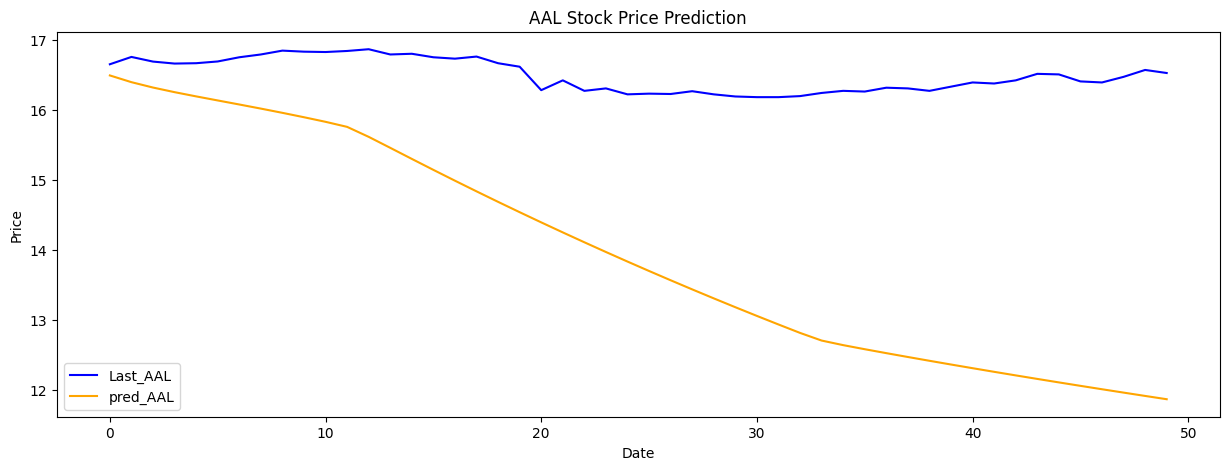

In [53]:
# Line graph of pred_AAL and Last_AAL
val_graph_data = val_graph_data.iloc[:50,:]

plt.figure(figsize=(15, 5))
plt.plot(val_graph_data.index, val_graph_data[('Last', 'AAL')], label='Last_AAL', color='blue')
plt.plot(val_graph_data.index, val_graph_data['pred_AAL'], label='pred_AAL', color='orange')
plt.title('AAL Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:


splits=2

mycv = PanelSplit(periods = reg_data.month, n_splits = splits, gap = 0, test_size=1)

hidden_neurons = round((len(Xcols)+1)/3)

nn_model = nn(
    max_iter=1000,
    verbose=True,
    hidden_layer_sizes=(hidden_neurons),
    early_stopping=True,
    validation_fraction=0.2,
    n_iter_no_change=10,
    solver ='adam',
    learning_rate_init=0.001, # default is 0.001
    shuffle=False # important to keep off for time series
    )

pipeline = Pipeline([
     ('scaler', StandardScaler()),
     ('pca', PCA(n_components=0.95)),
     ('model', nn_model)
 ], verbose=True)

fit = cross_val_fit(pipeline, reg_data[Xcols], reg_data['qty'], mycv, n_jobs=1)
predictions = extract_cv_fit(fit, test_2015_nov[Xcols])
# Export post-processed prediction
testresults = test_2015_nov
testresults.index = range(len(testresults))
testresults['item_cnt_month'] = predictions['pred_mean']

testresults['item_cnt_month'].clip(0, 20, inplace=True)

to_export = testresults[['ID', 'item_cnt_month']]
to_export.to_csv(r'../output/predictions_nn_202505081730.csv', index=False)

In [ ]:
# Recode the ym variable to an index
# Create a time trend variable from ym values
unique_ym = sorted(reg_data['ym'].unique())
ym_to_trend = {ym: i for i, ym in enumerate(unique_ym)}
reg_data['month'] = reg_data['ym'].map(ym_to_trend)
# Declare some variables as categorical
reg_data['shop_id']          = reg_data['shop_id'].astype('category')
reg_data['item_id']          = reg_data['item_id'].astype('category')
reg_data['item_category_id'] = reg_data['item_category_id'].astype('category')

# month of year
reg_data['month_of_year'] = reg_data['month'].mod(12)

reg_data['month_of_year'] = reg_data['month_of_year'].astype('category')
# Clipping variables: the test data has range (0,20)
vars_to_clip = ['qty', 'qty_lag1', 'qty_lag2', 'qty_lag3', 'qty_lag4', 'qty_lag5', 'qty_lag6', 'qty_roll3_lag1', 'qty_roll3_lag2', 'qty_roll3_lag3', 'qty_roll6_lag1', 'qty_roll6_lag2', 'qty_roll6_lag3', 'qty_roll12_lag1', 'qty_roll12_lag2', 'qty_roll12_lag3']

for var in vars_to_clip:
    # Clip the variable to the range (0, 20)
    reg_data[var].clip(0, 20, inplace=True)
# One-hot encode categorical variables
item_category = pd.get_dummies(reg_data['item_category_id'], prefix='item_category', dtype=np.int8)
stores = pd.get_dummies(reg_data['shop_id'], prefix='shop', dtype=np.int8)
months = pd.get_dummies(reg_data['month_of_year'], prefix='month', dtype=np.int8)

# Combine the one-hot encoded variables with the original DataFrame
reg_data = pd.concat([reg_data, item_category, stores, months], axis=1)



In [ ]:
reg_data
# Final Test data is where month == 34 (2015 Nov)
test_2015_nov = reg_data[reg_data['month'] == 34]
reg_data = reg_data[reg_data['month'] != 34]
reg_data = reg_data[reg_data['month'] > 3] # chopping the data
reg_data.index = range(len(reg_data))
cols = ""
for c in reg_data.columns:
    cols += "'" + c + "', "
cols = cols[:-2]  # remove last comma and space
print(cols)
Xcols = [
    'qty_lag1', 'qty_lag2', 'qty_lag3', 'qty_lag4', 'qty_lag5', 'qty_lag6', 'qty_roll3_lag1', 'qty_roll3_lag2', 'qty_roll3_lag3', 'qty_roll6_lag1', 'qty_roll6_lag2', 'qty_roll6_lag3', 'qty_roll12_lag1', 'qty_roll12_lag2', 'qty_roll12_lag3', 'relative_price_lag1', 'relative_price_lag2', 'relative_price_lag3', 'relative_price_lag4', 'relative_price_lag5', 'relative_price_lag6', 'relative_price3_lag1', 'relative_price3_lag2', 'relative_price3_lag3', 'product_qty_pclag1', 'product_qty_pclag2', 'product_qty_pclag3', 'shop_qty_pclag1', 'shop_qty_pclag2', 'shop_qty_pclag3', 'qty_substitute_prod_pclag1', 'qty_substitute_prod_pclag2', 'qty_substitute_prod_pclag3', 'price_mean_complement_prod_1_pclag1', 'price_mean_complement_prod_1_pclag2', 'price_mean_complement_prod_1_pclag3', 'price_mean_complement_prod_2_pclag1', 'price_mean_complement_prod_2_pclag2', 'price_mean_complement_prod_2_pclag3', 'price_mean_complement_prod_3_pclag1', 'price_mean_complement_prod_3_pclag2', 'price_mean_complement_prod_3_pclag3', 'price_mean_substitute_shop_1_pclag1', 'price_mean_substitute_shop_1_pclag2', 'price_mean_substitute_shop_1_pclag3', 'price_mean_substitute_shop_2_pclag1', 'price_mean_substitute_shop_2_pclag2', 'price_mean_substitute_shop_2_pclag3', 'price_mean_substitute_shop_3_pclag1', 'price_mean_substitute_shop_3_pclag2', 'price_mean_substitute_shop_3_pclag3', 
    'item_category_0', 'item_category_2', 'item_category_3', 'item_category_5', 'item_category_6', 'item_category_7', 'item_category_9', 'item_category_11', 'item_category_12', 'item_category_15', 'item_category_16', 'item_category_19', 'item_category_20', 'item_category_21', 'item_category_22', 'item_category_23', 'item_category_24', 'item_category_25', 'item_category_26', 'item_category_27', 'item_category_28', 'item_category_29', 'item_category_30', 'item_category_31', 'item_category_33', 'item_category_34', 'item_category_35', 'item_category_36', 'item_category_37', 'item_category_38', 'item_category_40', 'item_category_41', 'item_category_42', 'item_category_43', 'item_category_44', 'item_category_45', 'item_category_47', 'item_category_49', 'item_category_54', 'item_category_55', 'item_category_56', 'item_category_57', 'item_category_58', 'item_category_60', 'item_category_61', 'item_category_62', 'item_category_63', 'item_category_64', 'item_category_65', 'item_category_67', 'item_category_69', 'item_category_70', 'item_category_71', 'item_category_72', 'item_category_73', 'item_category_74', 'item_category_75', 'item_category_76', 'item_category_77', 'item_category_78', 'item_category_79', 'item_category_83', 'shop_2', 'shop_3', 'shop_4', 'shop_5', 'shop_6', 'shop_7', 'shop_10', 'shop_12', 'shop_14', 'shop_15', 'shop_16', 'shop_18', 'shop_19', 'shop_21', 'shop_22', 'shop_24', 'shop_25', 'shop_26', 'shop_28', 'shop_31', 'shop_34', 'shop_35', 'shop_36', 'shop_37', 'shop_38', 'shop_39', 'shop_41', 'shop_42', 'shop_44', 'shop_45', 'shop_46', 'shop_47', 'shop_48', 'shop_49', 'shop_50', 'shop_52', 'shop_53', 'shop_55', 'shop_56', 'shop_57', 'shop_58', 'shop_59', 'month_0', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11'
]
len(Xcols)
reg_data['ID'].unique()
splits=2

mycv = PanelSplit(periods = reg_data.month, n_splits = splits, gap = 0, test_size=1)

hidden_neurons = round((len(Xcols)+1)/3)

nn_model = nn(
    max_iter=1000,
    verbose=True,
    hidden_layer_sizes=(hidden_neurons),
    early_stopping=True,
    validation_fraction=0.2,
    n_iter_no_change=10,
    solver ='adam',
    learning_rate_init=0.001, # default is 0.001
    shuffle=False # important to keep off for time series
    )

pipeline = Pipeline([
     ('scaler', StandardScaler()),
     ('pca', PCA(n_components=0.95)),
     ('model', nn_model)
 ], verbose=True)

fit = cross_val_fit(pipeline, reg_data[Xcols], reg_data['qty'], mycv, n_jobs=1)
predictions = extract_cv_fit(fit, test_2015_nov[Xcols])
# Export post-processed prediction
testresults = test_2015_nov
testresults.index = range(len(testresults))
testresults['item_cnt_month'] = predictions['pred_mean']

testresults['item_cnt_month'].clip(0, 20, inplace=True)

to_export = testresults[['ID', 'item_cnt_month']]
to_export.to_csv(r'../output/predictions_nn_202505081730.csv', index=False)